Notebook adapted from prediction_lr.ipynb

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle

from prediction_tools import error_analysis, get_youden_threshold, \
    plot_confusion_matrix, plot_prc, plot_roc, print_metrics, print_params
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': list(range(2, 5)),
    'learning_rate': np.linspace(0, 0.2, 3),
    'n_estimators': list(range(100, 201, 10)),
    'gamma': np.linspace(0, 0.5, 6),
#     'min_child_weight': list(range(2, 7, 2)),
#     'max_delta_step': list(range(0, 11, 2)),
#     'subsample': [0.5, 0.8, 1],
#     'colsample_bytree': [0.5, 0.8, 1],
    'scale_pos_weight': [16],  # Hard-coded based on prevalence of hyperchloremia (~6%)
    'random_state': [60611],
    'eval_metric': ['aucpr']
}

clf = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', cv=4, n_jobs=-1)

# Read in data

In [2]:
X_train = pd.read_csv('train_data.csv') \
            .set_index(['subject_id', 'hadm_id', 'icustay_id'])
y_train_chl_110 = X_train['chl_110'].tolist()
X_train = X_train.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

X_test = pd.read_csv('test_data.csv') \
           .set_index(['subject_id', 'hadm_id', 'icustay_id'])
y_test_chl_110 = X_test['chl_110'].tolist()
X_test = X_test.drop(columns=['chloride_max', 'chl_110'])  # drop 'cluster'

print "%d features, %d training rows, %s test rows" % \
      (len(X_train.columns), len(X_train), len(X_test))

36 features, 23330 training rows, 9999 test rows


# Whole dataset

Selected parameters:
- eval_metric: aucpr
- scale_pos_weight: 16
- learning_rate: 0.1
- n_estimators: 140
- random_state: 60611
- max_depth: 2
- gamma: 0.0


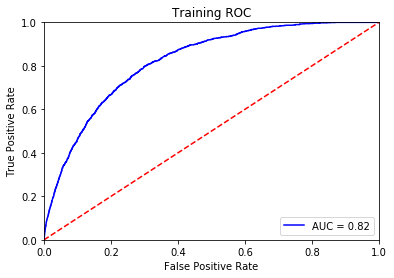

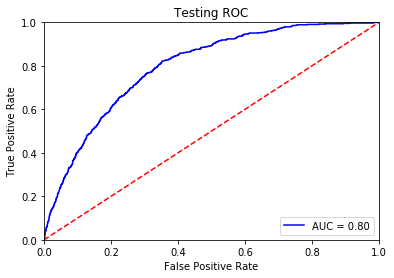

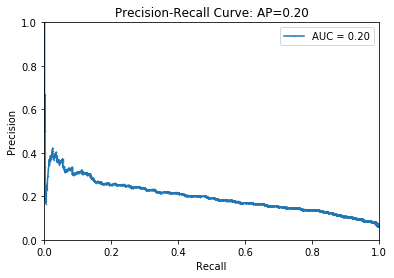

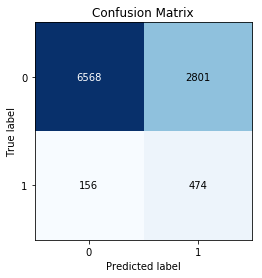

Precision:  0.14473282442748092
Recall   :  0.7523809523809524
F-measure:  0.24276568501920615


In [3]:
clf.fit(X_train, y_train_chl_110)
print_params(clf, param_grid.keys())

train_probabilities = clf.predict_proba(X_train)[:,1]
youden_threshold = get_youden_threshold(y_train_chl_110, train_probabilities)
plot_roc(y_train_chl_110, train_probabilities, "Training ROC")

test_probabilities = clf.predict_proba(X_test)[:,1]
test_predictions = ((test_probabilities - youden_threshold) >= 0).astype(int)
plot_roc(y_test_chl_110, test_probabilities, "Testing ROC")
plot_prc(y_test_chl_110, test_probabilities)
print_metrics(y_test_chl_110, test_predictions)

# Error analysis

In [4]:
with open("./error_analysis/scaler.pickle", 'rb') as f:
    to_standardize, scaler = pickle.load(f)

# It looks like the scaler has some precision problems when scaling
# back values of 0, so round to six decimals to address this.
X_train[to_standardize] = scaler.inverse_transform(X_train[to_standardize]).round(6)

error_analysis(X_train, y_train_chl_110, train_probabilities)


False Positives


prediction_tools.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  false_positives['probability'] = y_pred[indices]


,,,day_1_chl,age,gender,chloride_input_meq,fluid_net_input_ml,EPAP,IPAP,LPM,MeanAirwayPressure,heartrate_max,...,other_neurological,chronic_pulmonary,diabetes_complicated,renal_failure,solid_tumor,obesity,fluid_electrolyte,drug_abuse,depression,probability
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
831,185983,223445,108.0,84.205479,1,546.600000,2553.000000,0.0,0.0,0.0,1.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906321
17028,111318,297955,109.0,73.353425,1,30.800000,2345.000000,0.0,0.0,0.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.910468
68798,147436,271036,109.0,82.868493,1,350.180769,1284.414122,0.0,0.0,0.0,1.0,103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.916163
18419,116798,292868,108.0,72.454795,1,516.000000,3578.090627,0.0,0.0,0.0,1.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.926582
2090,146557,276865,109.0,76.704110,0,753.640756,8961.551811,0.0,0.0,0.0,1.0,127.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.943641



False Negatives


prediction_tools.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  false_negatives['probability'] = y_pred[indices]


,,,day_1_chl,age,gender,chloride_input_meq,fluid_net_input_ml,EPAP,IPAP,LPM,MeanAirwayPressure,heartrate_max,...,other_neurological,chronic_pulmonary,diabetes_complicated,renal_failure,solid_tumor,obesity,fluid_electrolyte,drug_abuse,depression,probability
subject_id,hadm_id,icustay_id,,,,,,,,,,,,,,,,,,,,,
23469,172927,260867,93.0,52.257534,0,0.000000,-1850.000000,0.0,0.0,0.0,0.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105227
18421,112184,288942,100.0,34.191781,1,172.260000,1165.712509,0.0,0.0,1.0,0.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102405
25524,148220,207777,99.0,77.556164,0,150.150000,-195.000000,0.0,0.0,1.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086993
2790,145471,254927,98.0,77.427397,1,58.622667,3025.666667,0.0,0.0,1.0,0.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080186
23395,196876,286271,96.0,54.345205,1,58.520000,2715.500000,0.0,0.0,0.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069641


# Pickle for combined plotting

In [5]:
with open('./pickle/xgb_whole.pickle', 'wb') as f:
    pickle.dump(("XGBoost", y_test_chl_110, test_probabilities), f)